# Node2Vec Script

First the required packages and the bank.csv file is loaded.

In [81]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import networkx as nx
from node2vec import Node2Vec
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.svm import SVC
import statsmodels.api as sm
import sklearn.metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

df = pd.read_csv('bank.csv',sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


## Recoding

The data is recoded in the following code 

In [82]:
df.job.unique()

array(['unemployed', 'services', 'management', 'blue-collar',
       'self-employed', 'technician', 'entrepreneur', 'admin.', 'student',
       'housemaid', 'retired', 'unknown'], dtype=object)

In [83]:
df.age = df.age.apply(lambda x: 0 if x < 25 else(1 if x < 35 else(2 if x < 50 else(3 if x < 65 else 4))))

#df.job = df.job.apply(lambda x: 0 if x == 'unemployed' else(1 if x == 'services' \
#                            else(2 if x == 'management' else(3 if x == 'blue-collar' \
#                                else(4 if x == 'self-employed' else(5 if x == 'technician' \
#                                    else(6 if x == 'entrepreneur' else(7 if x == 'admin.' \
#                        else(8 if x =='student' else(9 if x == 'housemaid' \
#                            else(10 if x == 'retired' else 11)))))))))))

#df.job = df.job.apply(lambda x: 0 if x == 'unemployed' or 'unknown' else(1 if x == 'services' \
#                        or x == 'management' or x == 'admin.' else(2 if x == 'blue-collar' or x == 'technician' \
#                                    or x == 'housemaid' else(3 if x == 'self-employed' or x == 'entrepreneur' \
#                                        else(4 if x == 'student' else 5)))))

df.job = df.job.apply(lambda x: 0 if x == 'student' else(2 if x == 'retired' else(3 if x == 'unemployed' or x == 'unknown' else 1)))


df.marital = df.marital.apply(lambda x: 0 if x == 'single' else(1 if x == 'married' else 2))

df.education = df.education.apply(lambda x: 0 if x == 'primary' else(1 if x == 'secondary' else(2 if x == 'tertiary' else 3)))

df.default = df.default.apply(lambda x: 0 if x == 'no' else 1)

df.balance = df.balance.apply(lambda x: 0 if x < 0 else(1 if x < 69. else(2 if x < 444. else(3 if x < 1480 else 4))))

df.housing = df.housing.apply(lambda x: 0 if x == 'no' else 1)

df.loan = df.loan.apply(lambda x: 0 if x == 'no' else 1)

df.contact = df.contact.apply(lambda x: 0 if x == 'telephone' else(1 if x == 'cellular' else 2))

df.pdays = df.pdays.apply(lambda x: 0 if x < 50 else 0)

df.poutcome = df.poutcome.apply(lambda x: 0 if x == 'failure' else(1 if x == 'success' else 2))

df.y = df.y.apply(lambda x: 0 if x == 'no' else 1)

df.drop(columns = ['day','month'],inplace=True)


In [84]:
df

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
0,1,3,1,0,0,4,0,0,1,79,1,0,0,2,0
1,1,1,1,1,0,4,1,1,1,220,1,0,4,0,0
2,2,1,0,2,0,3,1,0,1,185,1,0,1,0,0
3,1,1,1,2,0,3,1,1,2,199,4,0,0,2,0
4,3,1,1,1,0,1,1,0,2,226,1,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,1,1,1,1,0,0,1,0,1,329,5,0,0,2,0
4517,3,1,1,2,1,0,1,1,2,153,1,0,0,2,0
4518,3,1,1,1,0,2,0,0,1,151,11,0,0,2,0
4519,1,1,1,1,0,3,0,0,1,129,4,0,3,2,0


## MAG

The attributes for the MAG are selected below and the graph is thereafter generated.

In [85]:
X = df[['age','job','marital','education','balance','housing','duration']]
X.duration = X.duration.apply(lambda x: 0 if x < 400 else 1)
X

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,age,job,marital,education,balance,housing,duration
0,1,3,1,0,4,0,0
1,1,1,1,1,4,1,0
2,2,1,0,2,3,1,0
3,1,1,1,2,3,1,0
4,3,1,1,1,1,1,0
...,...,...,...,...,...,...,...
4516,1,1,1,1,0,1,0
4517,3,1,1,2,0,1,0
4518,3,1,1,1,2,0,0
4519,1,1,1,1,3,0,0


In [6]:
# age
age_alpha0 = 0.90
age_beta1 = 0.80
age_beta2 = 0.60
age_beta3 = 0.40
age_beta4 = 0.20

aff_age = np.array([[age_alpha0,age_beta1,age_beta2,age_beta3,age_beta4],
                    [age_beta1,age_alpha0,age_beta1,age_beta2,age_beta3],
                    [age_beta2,age_beta1,age_alpha0,age_beta1,age_beta2],
                    [age_beta3,age_beta2,age_beta1,age_alpha0,age_beta1],
                    [age_beta4,age_beta3,age_beta2,age_beta1,age_alpha0]])


# job

job_alpha0 = 0.90 # self
job_beta_wf = 0.60 # workforce
job_beta_nwf = 0.60 # not worforce

#aff_job = np.array([[job_alpha0, job_beta_wf , job_beta_wf , job_beta_wf , job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_alpha0, job_beta_wf, job_beta_wf, job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_alpha0, job_beta_wf, job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_beta_wf, job_alpha0, job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_beta_wf, job_beta_wf, job_alpha0, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_beta_wf, job_beta_wf, job_beta_nwf, job_alpha0]])

# employment
emp_alpha0 = 0.90 # self
emp_beta_wf = 0.75 # beta workforce / employed / unemployed vs student
emp_beta_ret = 0.70 # beta retired vs workforce
emp_beta_sr = 0.20 # gen gap student / retired

aff_job = np.array([[emp_alpha0,emp_beta_wf,emp_beta_sr,emp_beta_wf],
                    [emp_beta_wf,emp_alpha0,emp_beta_ret,emp_beta_wf],
                    [emp_beta_sr,emp_beta_ret,emp_alpha0,emp_beta_ret],
                    [emp_beta_wf,emp_beta_wf,emp_beta_ret,emp_alpha0]])


# marital

mar_alpha0 = 0.85
mar_beta1 = 0.65

aff_mar = np.array([[mar_alpha0, mar_beta1, mar_beta1],
                    [mar_beta1, mar_alpha0, mar_beta1],
                    [mar_beta1, mar_beta1, mar_alpha0]])

# education
edu_alpha0 = 0.85
edu_beta1 = 0.70
edu_beta2 = 0.55
edu_beta3 = 0.40

aff_edu = np.array([[edu_alpha0,edu_beta1,edu_beta2,edu_beta3],
                    [edu_beta1,edu_alpha0,edu_beta1,edu_beta2],
                    [edu_beta2,edu_beta1,edu_alpha0,edu_beta1],
                    [edu_beta3,edu_beta2,edu_beta1,edu_alpha0]])


# balance
inc_alpha0 = 0.85
inc_beta1 = 0.70
inc_beta2 = 0.60
inc_beta3 = 0.50
inc_beta4 = 0.40
inc_beta5 = 0.25

aff_bal = np.array([[inc_alpha0,inc_beta1,inc_beta2,inc_beta3,inc_beta4],
                    [inc_beta1,inc_alpha0,inc_beta1,inc_beta2,inc_beta3],
                    [inc_beta2,inc_beta1,inc_alpha0,inc_beta1,inc_beta2],
                    [inc_beta3,inc_beta2,inc_beta1,inc_alpha0,inc_beta1],
                    [inc_beta4,inc_beta3,inc_beta2,inc_beta2,inc_alpha0]])

# housing
hous_alpha0 = 0.60
hous_beta1 = 0.40

aff_hous = np.array([[hous_alpha0,hous_beta1],
                     [hous_beta1,hous_alpha0]])


# duration
dur_alpha0 = 0.70
dur_alpha1 = 0.95
dur_beta1 = 0.25

aff_dur = np.array([[dur_alpha0,dur_beta1],
                  [dur_beta1,dur_alpha1]])

# outcome

#y_alpha1 = 0.95
#y_beta1 = 0.25

#aff_y = np.array([[y_alpha1,y_beta1],
#                  [y_beta1,y_alpha1]])

aff = {}
aff = {0:aff_age, 1:aff_job ,2:aff_mar ,3:aff_edu ,4:aff_bal ,5:aff_hous,6:aff_dur}

In [7]:
x = X[['age','job','marital','education','balance','housing','duration']]
x = x.to_numpy()
x = x.T

P_u_v = np.empty((len(x.T),len(x.T)))
prob_u_v = np.empty((len(x),1))
u = np.empty((len(x),1))
v = np.empty((len(x),1))

# create probability for connection between u and v
for i in range(len(x.T)):
    u = x[:,i]

    for k in range(len(x.T)):
        v = x[:,k]

        for j in range(len(x)):
            aff_current = aff[j]
            prob_u_v[j] = aff_current[u[j],v[j]]

        P_u_v[i,k] = np.prod(prob_u_v) 

In [8]:
A = np.triu(P_u_v,1)

for i in range(len(P_u_v)):
    for j in range(len(P_u_v)):
        if A[i,j] > np.random.rand():
            A[i,j] = 1
        else:
            A[i,j] = 0



In [9]:
A = A + A.T - np.diag(np.diag(A))
np.sum(A) / 2

737032.0

In [10]:
G = nx.from_numpy_matrix(A)

## Node2Vec

Below the node embeddings are generated using the node2vec algorithm

In [11]:
node2vec = Node2Vec(G, dimensions=6, walk_length=30, num_walks=200, workers=1)

Computing transition probabilities:   0%|          | 0/4521 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 200/200 [1:29:36<00:00, 26.88s/it]


In [12]:
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [13]:
model.wv.save_word2vec_format('embeddings')

The node embeddings are saved and are loaded again. The node embeddings are saved as the node2vec prodedure can take up a lot of time.

In [86]:
t = pd.read_csv('embeddings', delimiter = " ", index_col=0, header = None)
t.sort_index(inplace=True)
t.columns = ['x1','x2','x3','x4','x5','x6']
t = t.to_numpy()
t.shape

(4521, 6)

## Downstream Machine Learning

Below the node embeddingare used for downstream machine learning

### ANN

In [120]:
x_train, x_test, y_train, y_test = train_test_split(t,df.y, test_size = 0.2, shuffle=True)

In [121]:
x_train_tf = tf.convert_to_tensor(x_train)
x_test_tf = tf.convert_to_tensor(x_test)
y_train_tf = tf.convert_to_tensor(y_train)
y_test_tf = tf.convert_to_tensor(y_test)

model = Sequential()

model.add(Dense(12, activation='relu', name='layer1'))
model.add(Dense(8, activation='relu', name='layer2'))
model.add(Dense(1, activation='sigmoid', name='layer3'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train_tf, y_train_tf, validation_data=(x_test_tf,y_test_tf), epochs=50, batch_size=10)

Epoch 1/50
362/362 [==============================] - 2s 3ms/step - loss: 0.5235 - accuracy: 0.8846 - val_loss: 0.3422 - val_accuracy: 0.8972
Epoch 2/50
362/362 [==============================] - 1s 3ms/step - loss: 0.3627 - accuracy: 0.8839 - val_loss: 0.3154 - val_accuracy: 0.8972
Epoch 3/50
362/362 [==============================] - 1s 2ms/step - loss: 0.3269 - accuracy: 0.8882 - val_loss: 0.2986 - val_accuracy: 0.8972
Epoch 4/50
362/362 [==============================] - 1s 4ms/step - loss: 0.3173 - accuracy: 0.8827 - val_loss: 0.2893 - val_accuracy: 0.8972
Epoch 5/50
362/362 [==============================] - 1s 3ms/step - loss: 0.3121 - accuracy: 0.8811 - val_loss: 0.2881 - val_accuracy: 0.8972
Epoch 6/50
362/362 [==============================] - 1s 3ms/step - loss: 0.3004 - accuracy: 0.8863 - val_loss: 0.2891 - val_accuracy: 0.8972
Epoch 7/50
362/362 [==============================] - 1s 3ms/step - loss: 0.2988 - accuracy: 0.8838 - val_loss: 0.2899 - val_accuracy: 0.8983
Epoch 

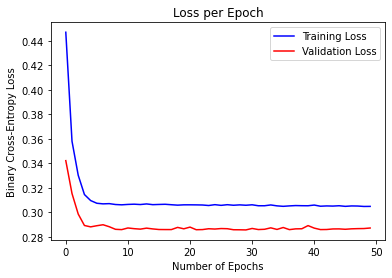

In [122]:
plt.plot(history.history['loss'],label = 'Training Loss', color = 'blue')
plt.plot(history.history['val_loss'],label = 'Validation Loss', color = 'red')
plt.xlabel('Number of Epochs')
plt.ylabel('Binary Cross-Entropy Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()

In [123]:
model.layers[2].output

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'layer3')>

In [124]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 12)                84        
_________________________________________________________________
layer2 (Dense)               (None, 8)                 104       
_________________________________________________________________
layer3 (Dense)               (None, 1)                 9         
Total params: 197
Trainable params: 197
Non-trainable params: 0
_________________________________________________________________


In [125]:
np.sum(y_train) / len(y_train)

0.11836283185840708

### Logistic Regression

In [126]:
log_reg = sm.Logit(y_train, x_train).fit()
print(log_reg.summary())


Optimization terminated successfully.
         Current function value: 0.307106
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 3616
Model:                          Logit   Df Residuals:                     3610
Method:                           MLE   Df Model:                            5
Date:                Sat, 10 Jul 2021   Pseudo R-squ.:                  0.1555
Time:                        23:35:36   Log-Likelihood:                -1110.5
converged:                       True   LL-Null:                       -1315.0
Covariance Type:            nonrobust   LLR p-value:                 3.535e-86
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.6161      0.244     10.708      0.000       2.137       3.095
x2             2.3026      0.

In [127]:
clf = LogisticRegression(random_state=0,max_iter=500).fit(x_train, y_train)
print('Training Accuracy: ',clf.score(x_train,y_train))
print('Validation Accuracy: ',clf.score(x_test,y_test))

Training Accuracy:  0.8763827433628318
Validation Accuracy:  0.8994475138121547


### Support Vector Machine

In [128]:
svm_y = np.empty((len(df.y),1))

for i in range(len(df.y)):
    if df.y.iloc[i] == 1:
        svm_y[i] = 1
    else:
        svm_y[i] = -1

svm_y.astype(int)

array([[-1],
       [-1],
       [-1],
       ...,
       [-1],
       [-1],
       [-1]])

In [129]:
x_train, x_test, y_train, y_test = train_test_split(t,svm_y, test_size = 0.2, shuffle=True)

In [130]:
clf = SVC()
clf.fit(x_train,y_train)
print('Training Accuracy: ',clf.score(x_train,y_train))
print('Validation Accuracy: ',clf.score(x_test,y_test))

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training Accuracy:  0.886891592920354
Validation Accuracy:  0.876243093922652


### Random Forest Classifier

In [131]:
clf = RandomForestClassifier(max_depth=None, random_state=0)

clf.fit(x_train, y_train)
print('Training Accuracy: ',clf.score(x_train,y_train))
print('Validation Accuracy: ',clf.score(x_test,y_test))

<ipython-input-131-17489b573de9>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


Training Accuracy:  1.0
Validation Accuracy:  0.8740331491712707


### AdaBoost

In [132]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(x_train, y_train)
print('Training Accuracy: ',clf.score(x_train,y_train))
print('Validation Accuracy: ',clf.score(x_test,y_test))

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training Accuracy:  0.8951880530973452
Validation Accuracy:  0.8718232044198895


### QDA

In [133]:
clf = QDA()
clf.fit(x_train, y_train)
print('Training Accuracy: ',clf.score(x_train,y_train))
print('Validation Accuracy: ',clf.score(x_test,y_test))

Training Accuracy:  0.8606194690265486
Validation Accuracy:  0.8464088397790055


/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
